# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability



In [6]:
# import packages
import pandas as pd
import nbconvert
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>




In [7]:
# data setup
df = pd.read_csv(r'C:\Users\trtu2001\Desktop\Analyze AB Test Result\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [8]:
# Check rows in dataset
df.shape[0]

294478

In [9]:
# Check total unique users in dataset
df['user_id'].nunique()

290584

In [10]:
# Check converted user proportion
df.query('converted == 1')['user_id'].count()/df['user_id'].nunique()

0.12126269856564711

In [11]:
# Check inaccurate data
df.loc[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1


In [12]:
# check number of times of inaccurate data
control_inaccuracy = ((df['group'] == 'control') & (df['landing_page'] == 'new_page')).sum() 
treatment_inaccuracy = ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')).sum()
treatment_inaccuracy + control_inaccuracy

3893

In [13]:
# check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### Handle inaccurate data - data does not match between landing_page and group
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [14]:
# Check data treatment group
df[(df['group'] == 'treatment')&(df['landing_page'] == 'new_page')].head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [15]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = pd.concat([df[(df['group'] == 'treatment')&(df['landing_page'] == 'new_page')], df[(df['group'] == 'control')&(df['landing_page'] == 'old_page')]])

In [16]:
# Double check all of the incorrect rows were removed from df2 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [17]:
# Check total unique users
df2['user_id'].nunique()

290584

In [18]:
# Find out which user_id is duplicated
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
# Display the rows for the duplicate
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [20]:
# Check user_id = 773192 which is duplicated
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [21]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop(index=2893)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted


In [22]:
# Calculate conversion proportion of total population
p_population = df2.converted.mean()
p_population

0.11959708724499628

In [23]:
# Check the conversion proportion of control group
p_control = df2.query('group == "control"')['converted'].mean()
p_control

0.1203863045004612

In [24]:
# Check the conversion proportion of treatment group
p_treatment = df2.query('group == "treatment"')['converted'].mean()
p_treatment

0.11880806551510564

In [25]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

In [26]:
# Check new page probability
(df2['landing_page'] == 'new_page').mean() 

0.5000619442226688

In [27]:
# Check the same occurrence that new page and treatment group 
# (only treatment group user will receive new page)
(df2['landing_page'] == 'new_page').mean() == (df2['group'] == 'treatment').mean()

True

According to the results from part (a) to part (d), the treatment group does not seem to lead to more conversions (0.1188 < 0.1204) even though the sample size of treatment and control groups are the nearly the same (The probability that an individual received the new page is roundly 0.5)

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  



For now, consider you need to make the decision just based on all the data provided.  

 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses ($H_0$ and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

<p>

$$H_0: p_{old} \ge p_{new}$$

$$H_1: p_{old} < p_{new}$$

</p>

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>

$$p_{new} = p_{old} = p_{population}$$

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



In [28]:
# Set p_new under null hypothesis
p_new = p_population
p_new

0.11959708724499628

In [29]:
# Set p_old under null hypothesis
p_old = p_population
p_old

0.11959708724499628

In [30]:
# number of observations in treatment group
n_new = (df2['group'] == 'treatment').sum()
n_new

145310

In [31]:
# number of observations in control group
n_old = (df2['group'] == 'control').sum()
n_old

145274

In [32]:
# check total new and old with sample data
n_new + n_old == df2.shape[0]

True

**Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>



In [33]:
# Simulate a Sample for the Treatment Group
new_page_converted = []
for _ in range(n_new):
    new = int(np.random.choice([1,0], 1, replace=True, p=[p_new, 1-p_new]))
    new_page_converted.append(new)     


**Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [34]:
# Simulate a Sample for the Control Group
old_page_converted = []
for _ in range(n_old):
    old = int(np.random.choice([1,0], 1, replace=True, p=[p_old, 1-p_old]))
    old_page_converted.append(old) 

**Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for simulated samples from the parts (e) and (f) above**

In [35]:
# Find the difference in the "converted" probability
p_new_converted = np.array(new_page_converted).mean()
p_old_converted = np.array(old_page_converted).mean()
diff = p_new_converted - p_old_converted
diff

0.00010116673520856045


**Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [36]:
# Sampling distribution 
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diff = new_converted_simulation - old_converted_simulation

p_diff

array([ 0.00017013,  0.0002803 ,  0.00193217, ..., -0.00053892,
        0.00012157,  0.00070685])

**Histogram**<br> 
Plot a histogram of the **p_diffs**. <br><br>




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


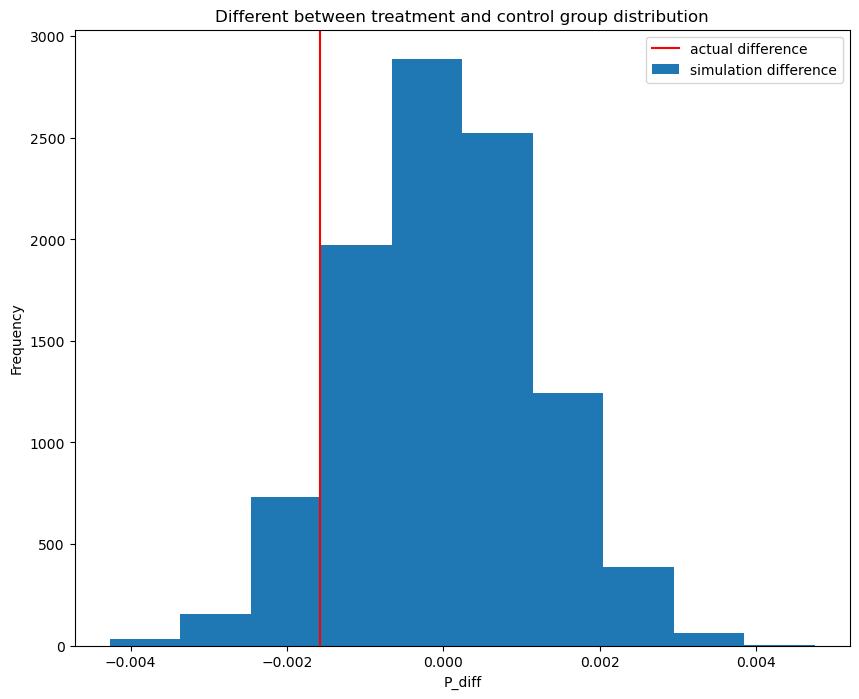

In [37]:
# bins = np.arange(min(p_diff)-0.001, max(p_diff)+0.001,0.009)
plt.figure(figsize=[10,8])
plt.hist(x=p_diff);
plt.axvline(x=obs_diff, color='r')
plt.title("Different between treatment and control group distribution")
plt.xlabel("P_diff")
plt.ylabel("Frequency")
plt.legend(loc='best')
plt.legend(["actual difference", "simulation difference"],loc="best")
plt.show()

**What proportion of the p_diffs are greater than the actual difference observed in the `df2` data?**

In [38]:
(p_diff > obs_diff).mean()

0.9109

**Explain the calculation above**
- This value is called p_value in scientific studies, for every point of data here will represent one more extreme point of data that we can observe that support the null hypothesis in the most favor of the alternative hypothesis.
- Because the probability that we observe data support the null hypothesis in the most favor of alternative hypothesis is big (0.5135 > $\alpha = 0.05$ - the threshold that we are allowed to make mistake when reject null hypothesis). In this case, if we reject the null hypothesis, the probability we will make mistake is 0.5135. So that this value signifies that we can not reject the null hypothesis, that is there is not difference between conversion rate between the old and new page.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 




In [39]:
# number of conversions with the old_page
convert_old = df2.query('group == "control"')['converted'].sum()

# number of conversions with the new_page
convert_new = df2.query('group == "treatment"')['converted'].sum()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"')['user_id'].count()

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

**m.** Use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---


In [40]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
# right-tailed test for hypothesis testing 
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts j. and k.?**<br><br>



p_value = 0.9051 > $\alpha = 0.05$ so that we can not reject the null hypothesis, which means there is no difference between the old and the new page. They agree with the findings in part j. and k.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should we be performing in this case?

Regression model that can be performed in this case that is: 
- Dependent variable is converted value (conversion or no conversion)
- Independent variable is dummy variables containing which version of page (new_page and old_page). 

Because the value of dependent variable only in (0,1) so that this will be logistic model.

The goal is to use **statsmodels** library to fit the regression model specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. 

In [41]:
# generate intercept column = 1
df2['intercept'] = 1
# merge dummy variables into data
df2['ab_page'] = pd.get_dummies(df2.landing_page).iloc[:,0]

Use **statsmodels** to instantiate regression model on the two columns created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [42]:
# fit model using Logistic Regression
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [43]:
# model summary
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-10-04 13:12 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**What is the p-value associated with ab_page? Why does it differ from the value found in Part II?**<br><br>  




p_value associated with ab_page is 0.1899 <br>
The reason why it differs from p_value in Part II: 
- Null hypotheses are different. Part II null hypothesis is p_old = p_new (both p are conversion rate) while Part III the null hypothesis is ab_page coefficient = 0.
- Part II is one sided (right-tailed test) while Part III is 2 sided test.

p_value of ab_page is greater than Type I error rate $\alpha = 0.05$

**Considering other things that might influence whether or not an individual converts. Discuss pros and cons of adding variables into regression model**

It is a good idea to consider other factors to add into regression model because the current model prerformance is not good due to the coefficient of ab_page is not statistically significant, which means it does not statistically explain the increase or decrease of the dependent variable. In addition, the Pseudo R-squared is too small in the range between 0 and 1 that we could consider this is a good model. 
There are advantages to adding additional terms into regression model: 
- The chance of multicollinearity will be higher
- Confounding variable could lead to the misterpretation in the explaining variable. 
- Leading to overfitting model.

**Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. Merge country into the data using countries.csv file
2. Does it appear that country had an impact on conversion? 



In [44]:
# Read the countries.csv
country = pd.read_csv(r'C:\Users\trtu2001\Desktop\Analyze AB Test Result\countries.csv')
country.shape
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
# Testing the key user_id in each data frame to define operation of the two objects
(country.user_id.sort_values().values != df2.user_id.sort_values().values).sum()

0

In [46]:
# Join with the df2 dataframe
df_merged = df2.merge(country, how ='inner', on='user_id')

In [47]:
# Create the necessary dummy variables
df_merged = df_merged.join(pd.get_dummies(df_merged['country']).iloc[:,1:3])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,0,0


In [48]:
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US'] * df_merged['ab_page']

**Fit your model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion. 


In [49]:
# Fit model, and summarize the results
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'US', 'ab_page', 'UK_ab_page', 'US_ab_page']])
result = logit_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-10-04 13:12 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

**Conclusion**<br>
For we may have assumption that our model was not exploited fully the data, therefore, we add necessary columns to fit a model. 
- According to the model summary, the p_values of UK_ab_page and US_ab_page is greater than 0.05 so that we can not confirm a non zero relationship between the probability to be converted of a user and the interaction between the page and his country.
- We fail to reject the null hypothesis (the coefficient = 0) 
- Comment on effect of interaction between page and country to predict the conversion 
    - The probability of conversion will be higher in ascending order given that the user lives in UK, CA, US respectively.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [60]:
from nb_offline_convert import OfflineHTMLExporter, OfflineWebPDFExporter

# convert to html
html_converter = OfflineHTMLExporter()
content, _ = html_converter.from_filename('Analyze_ab_test_results_notebook.ipynb')
with open(r"converted_file.html", "w", encoding = 'utf-8') as f:
    f.write(content)